In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import popoff
from Session import SessionLite, build_flu_array_single
from mpl_toolkits.mplot3d import Axes3D
from linear_model import PoolAcrossSessions, LinearModel, pca_session, LabelEncoder, largest_PC_trace, largest_PC_loading, do_pca
import loadpaths
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys, os, pickle, copy
from sklearn.decomposition import PCA
import warnings
import pandas as pd
import math, cmath
from tqdm import tqdm
import pop_off_functions as pof
import pop_off_plotting as pop
from IPython.core.debugger import Pdb
ipdb = Pdb()
import ptitprince as pt


## Load data in form of Jimmy's PAS object
warnings.warn('Targets in data, fix self.ever_targetted')
remove_targets = False
pas = PoolAcrossSessions(save_PCA=False, subsample_sessions=False,
                         remove_targets=remove_targets, remove_toosoon = True)
lm = pas.linear_models[0]
print(pas.sessions)

long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
{0: instance Mouse J064, run 10 of Session class, 1: instance Mouse J064, run 11 of Session class, 2: instance Mouse J064, run 14 of Session class, 3: instance Mouse RL070, run 28 of Session class, 4: instance Mouse RL070, run 29 of Session class, 5: instance Mouse RL117, run 29 of Session class, 6: instance Mouse RL117, run 30 of Session class, 7: instance Mouse RL123, run 22 of Session class, 8: instance Mouse RL116, run 32 of Session class, 9: instance Mouse RL116, run 33 of Session class}


In [4]:
## Create sessions object from PAS:

try:  # ensure sessions doesn't exist yet 
    sessions
    assert type(sessions) is dict
except NameError:
    pass

sessions = {}
int_keys_pas_sessions = pas.sessions.keys()
print(int_keys_pas_sessions)
i_s = 0
for ses in pas.sessions.values():  # load into sessions dict (in case pas skips an int as key)
    ses.signature = f'{ses.mouse}_R{ses.run_number}'
    sessions[i_s] = ses
    i_s += 1
#     if ses.signature != 'RL117_R29':  # one that used not to have spont data
#         sessions[i_s] = ses
#         i_s += 1
#     else:
#         f'{ses.signature} has been excluded !!! (because no spont data available)'
print(sessions)
assert len(sessions) == 10
pof.label_urh_arm(sessions=sessions)  # label arm and urh

# for kk, ss in sessions.items():
    
    
print('------------------------------------')
print(f'{len(sessions)} sessions are loaded')
tp_dict = pof.create_tp_dict(sessions=sessions)


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
{0: instance Mouse J064, run 10 of Session class, 1: instance Mouse J064, run 11 of Session class, 2: instance Mouse J064, run 14 of Session class, 3: instance Mouse RL070, run 28 of Session class, 4: instance Mouse RL070, run 29 of Session class, 5: instance Mouse RL117, run 29 of Session class, 6: instance Mouse RL117, run 30 of Session class, 7: instance Mouse RL123, run 22 of Session class, 8: instance Mouse RL116, run 32 of Session class, 9: instance Mouse RL116, run 33 of Session class}
URH and ARM trials have been labelled
------------------------------------
10 sessions are loaded


In [212]:
tp_dict['decoders'] = tp_dict['mutual']
tp_dict['decoders'] = tp_dict['decoders'][np.logical_and(tp_dict['decoders'] >- 2, 
                                                         tp_dict['decoders'] <= 4)]
tp_dict['decoders'] = tp_dict['decoders']#[::20]

dict_tt_train = {'hit/cr': ['hit', 'cr'], 
                 'miss/cr': ['miss', 'cr'],
                 'spont/cr': ['spont', 'cr'],
                 'hit/cr 10 trials': ['hit', 'cr']}

# lick_acc, lick_acc_split, lick_pred_split, ps_acc, ps_acc_split = {}, {}, {}, {}, {}
# ps_pred_split, lick_half, angle_dec, decoder_weights = {}, {}, {}, {}

## Train decoders (takes 20 mins per decoder type)

In [213]:
## Compute results decoders (note: CV of regularisation is down below in the notebook)

for key, list_tt_train in dict_tt_train.items():
    if key == 'hit/cr 10 trials':
        print(f'Now training {key} decoder')

        (lick_acc[key], lick_acc_split[key], lick_pred_split[key], ps_acc[key], 
         ps_acc_split[key], ps_pred_split[key], lick_half[key], angle_dec[key], 
         decoder_weights[key]) = pof.compute_accuracy_time_array_average_per_mouse(sessions=sessions, 
                                                       time_array=tp_dict['decoders'],
                                                      projected_data=False, 
                                                      reg_type='l2', regularizer=1, 
                                                      average_fun=pof.class_av_mean_accuracy,
                                                      split_fourway=True,
                                                        list_tt_training=list_tt_train,
                                                          concatenate_sessions_per_mouse=False)

0it [00:00, ?it/s]

Now training hit/cr 10 trials decoder
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


1it [00:05,  5.27s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


2it [00:10,  5.23s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


3it [00:15,  5.22s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


4it [00:20,  5.21s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


5it [00:26,  5.20s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


6it [00:31,  5.19s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


7it [00:36,  5.19s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


8it [00:41,  5.20s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


9it [00:46,  5.20s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


10it [00:52,  5.21s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


11it [00:57,  5.21s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


12it [01:02,  5.22s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


13it [01:07,  5.22s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


14it [01:12,  5.21s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


15it [01:18,  5.21s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


16it [01:23,  5.27s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


17it [01:28,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


18it [01:34,  5.32s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


19it [01:39,  5.34s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


20it [01:44,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


21it [01:50,  5.26s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


22it [01:55,  5.25s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


23it [02:00,  5.23s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


24it [02:05,  5.25s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


25it [02:11,  5.27s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


26it [02:16,  5.25s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


27it [02:21,  5.26s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


28it [02:26,  5.29s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


29it [02:32,  5.31s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


30it [02:37,  5.29s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


31it [02:42,  5.27s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


32it [02:48,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


33it [02:53,  5.32s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


34it [02:58,  5.34s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


35it [03:04,  5.42s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


36it [03:09,  5.41s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


37it [03:15,  5.41s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


38it [03:20,  5.39s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


39it [03:25,  5.39s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


40it [03:31,  5.38s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


41it [03:36,  5.36s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


42it [03:42,  5.37s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


43it [03:47,  5.37s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


44it [03:52,  5.37s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


45it [03:58,  5.37s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


46it [04:03,  5.37s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


47it [04:08,  5.36s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


48it [04:14,  5.36s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


49it [04:19,  5.36s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


50it [04:24,  5.36s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


51it [04:30,  5.37s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


52it [04:35,  5.38s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


53it [04:41,  5.38s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


54it [04:46,  5.37s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


55it [04:51,  5.37s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


56it [04:57,  5.34s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


57it [05:02,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


58it [05:07,  5.28s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


59it [05:12,  5.26s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


60it [05:18,  5.29s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


61it [05:23,  5.29s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


62it [05:28,  5.34s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


63it [05:34,  5.37s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


64it [05:39,  5.36s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


65it [05:44,  5.33s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


66it [05:50,  5.32s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


67it [05:55,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


68it [06:00,  5.29s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


69it [06:05,  5.28s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


70it [06:11,  5.27s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


71it [06:16,  5.26s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


72it [06:21,  5.24s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


73it [06:26,  5.24s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


74it [06:32,  5.29s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


75it [06:37,  5.32s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


76it [06:43,  5.34s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


77it [06:48,  5.35s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


78it [06:53,  5.33s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


79it [06:58,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


80it [07:04,  5.28s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


81it [07:09,  5.27s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


82it [07:14,  5.27s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


83it [07:19,  5.26s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


84it [07:25,  5.25s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


85it [07:30,  5.25s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


86it [07:35,  5.31s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


87it [07:41,  5.28s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


88it [07:46,  5.27s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


89it [07:51,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


90it [07:57,  5.32s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


91it [08:02,  5.34s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


92it [08:07,  5.36s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


93it [08:13,  5.32s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


94it [08:18,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


95it [08:23,  5.28s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


96it [08:28,  5.27s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


97it [08:34,  5.28s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


98it [08:39,  5.27s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


99it [08:44,  5.31s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


100it [08:50,  5.35s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


101it [08:55,  5.32s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


102it [09:00,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


103it [09:05,  5.28s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


104it [09:11,  5.31s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


105it [09:16,  5.33s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


106it [09:21,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


107it [09:27,  5.28s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


108it [09:32,  5.27s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


109it [09:37,  5.26s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


110it [09:42,  5.26s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


111it [09:48,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


112it [09:53,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


113it [09:58,  5.28s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


114it [10:04,  5.27s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


115it [10:09,  5.32s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


116it [10:14,  5.34s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


117it [10:20,  5.31s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


118it [10:25,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


119it [10:30,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


120it [10:36,  5.29s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


121it [10:41,  5.34s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


122it [10:46,  5.36s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


123it [10:52,  5.38s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


124it [10:57,  5.39s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


125it [11:03,  5.41s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


126it [11:08,  5.41s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


127it [11:14,  5.42s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


128it [11:19,  5.43s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


129it [11:24,  5.43s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


130it [11:30,  5.43s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


131it [11:35,  5.43s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


132it [11:41,  5.44s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


133it [11:46,  5.44s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


134it [11:52,  5.43s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


135it [11:57,  5.44s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


136it [12:02,  5.42s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


137it [12:08,  5.43s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


138it [12:13,  5.38s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


139it [12:18,  5.35s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


140it [12:24,  5.38s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


141it [12:29,  5.38s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


142it [12:34,  5.34s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


143it [12:40,  5.35s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


144it [12:45,  5.37s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


145it [12:51,  5.38s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


146it [12:56,  5.40s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


147it [13:02,  5.40s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


148it [13:07,  5.36s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


149it [13:12,  5.34s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


150it [13:17,  5.32s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


151it [13:23,  5.31s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


152it [13:28,  5.33s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


153it [13:33,  5.35s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


154it [13:39,  5.38s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


155it [13:44,  5.35s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


156it [13:49,  5.32s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


157it [13:55,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


158it [14:00,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


159it [14:05,  5.29s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


160it [14:10,  5.29s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


161it [14:16,  5.28s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


162it [14:21,  5.28s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


163it [14:26,  5.33s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


164it [14:32,  5.32s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


165it [14:37,  5.30s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


166it [14:42,  5.29s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


167it [14:48,  5.28s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


168it [14:53,  5.28s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


169it [14:58,  5.31s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


170it [15:04,  5.34s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


171it [15:09,  5.36s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


172it [15:14,  5.38s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


173it [15:20,  5.39s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


174it [15:25,  5.40s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


175it [15:31,  5.41s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


176it [15:36,  5.42s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


177it [15:42,  5.42s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


178it [15:47,  5.43s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


179it [15:52,  5.40s/it]

only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!
only using 10 trials per trial type!!


180it [15:58,  5.32s/it]


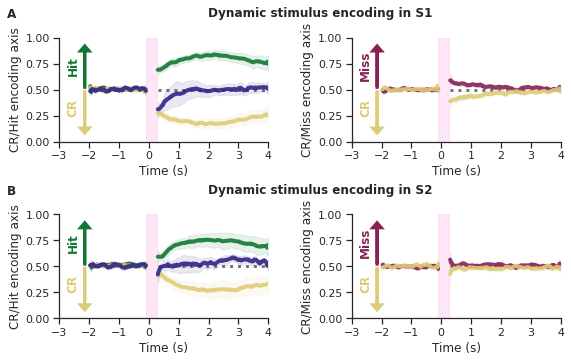

In [209]:
save_fig = True

fig = plt.figure(constrained_layout=False, figsize=(8, 5))
gs_dyn_dec = fig.add_gridspec(ncols=2, nrows=2, bottom=0.12, top=0.9, right=0.97, left=0.1,
                              wspace=0.4, hspace=0.7)
hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 0]), 's2': fig.add_subplot(gs_dyn_dec[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 1]), 's2': fig.add_subplot(gs_dyn_dec[1, 1])}
# hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0]), 's2': fig.add_subplot(gs_dyn_dec[2])}
# miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[1]), 's2': fig.add_subplot(gs_dyn_dec[3])}

time_array_plot = tp_dict['decoders']
time_array_plot[np.logical_and(time_array_plot >= -0.07, time_array_plot < 0.3)] = np.nan
# time_array_plot[time_array_plot < -1] = np.nan

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                              plot_tt=['hit', 'cr', 'spont'], plot_legend=False,
                                              time_array=time_array_plot)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                              plot_tt=['miss', 'cr'], plot_legend=False,
                                              time_array=time_array_plot)

for reg in ['s1' ,'s2']:
    hit_ax_dict[reg].set_title(f'Dynamic stimulus encoding in {reg.upper()}', 
                               x=1.25, y=1.14, fontdict={'weight': 'bold'})    
    miss_ax_dict[reg].set_title('')
    hit_ax_dict[reg].text(s=('A' if reg == 's1' else 'B'), x=-4.75, y=1.19,
                          fontdict={'weight': 'bold'})
    
if save_fig:        
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/fig3_main.pdf',
                bbox_to_inches='tight')

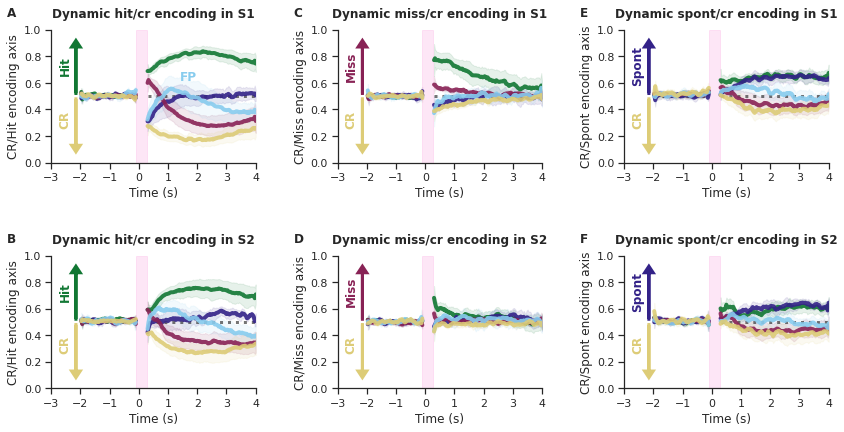

In [223]:
save_fig = True

fig = plt.figure(constrained_layout=False, figsize=(12, 6))
gs_dyn_dec = fig.add_gridspec(ncols=3, nrows=2, bottom=0.1, top=0.93, right=0.97, left=0.07,
                              wspace=0.4, hspace=0.7)

hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 0]), 's2': fig.add_subplot(gs_dyn_dec[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 1]), 's2': fig.add_subplot(gs_dyn_dec[1, 1])}
spont_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 2]), 's2': fig.add_subplot(gs_dyn_dec[1, 2])}


time_array_plot = tp_dict['decoders']
time_array_plot[np.logical_and(time_array_plot >= -0.07, time_array_plot < 0.3)] = np.nan

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False,
                                              indicate_fp=True)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False)


pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='spont/cr', ax_acc_ps=spont_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False)

for reg in ['s1', 's2']:
    hit_ax_dict[reg].text(s=('A' if reg == 's1' else 'B'), x=-4.5, y=1.1,
                          fontdict={'weight': 'bold'})
    miss_ax_dict[reg].text(s=('C' if reg == 's1' else 'D'), x=-4.5, y=1.1,
                          fontdict={'weight': 'bold'})
    spont_ax_dict[reg].text(s=('E' if reg == 's1' else 'F'), x=-4.5, y=1.1,
                          fontdict={'weight': 'bold'})
    
if save_fig:
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/fig3_supp1.pdf',
                bbox_to_inches='tight')
    

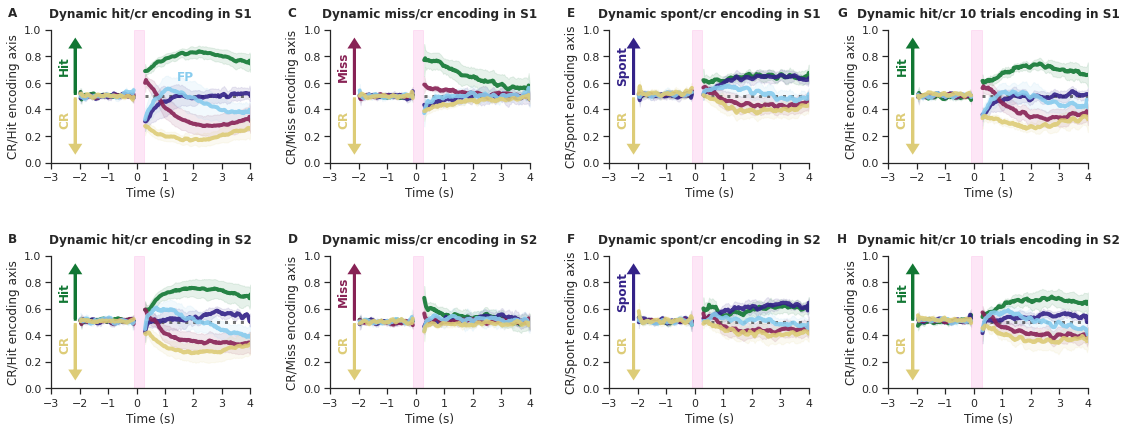

In [226]:
save_fig = True

fig = plt.figure(constrained_layout=False, figsize=(16, 6))
gs_dyn_dec = fig.add_gridspec(ncols=4, nrows=2, bottom=0.1, top=0.93, right=0.97, left=0.07,
                              wspace=0.4, hspace=0.7)

hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 0]), 's2': fig.add_subplot(gs_dyn_dec[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 1]), 's2': fig.add_subplot(gs_dyn_dec[1, 1])}
spont_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 2]), 's2': fig.add_subplot(gs_dyn_dec[1, 2])}
hit10_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 3]), 's2': fig.add_subplot(gs_dyn_dec[1, 3])}


time_array_plot = tp_dict['decoders']
time_array_plot[np.logical_and(time_array_plot >= -0.07, time_array_plot < 0.3)] = np.nan

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False,
                                              indicate_fp=True)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='spont/cr', ax_acc_ps=spont_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split, lick_pred_split=lick_pred_split,
                                              decoder_key='hit/cr 10 trials', ax_acc_ps=hit10_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False)

for reg in ['s1', 's2']:
    hit_ax_dict[reg].text(s=('A' if reg == 's1' else 'B'), x=-4.5, y=1.1,
                          fontdict={'weight': 'bold'})
    miss_ax_dict[reg].text(s=('C' if reg == 's1' else 'D'), x=-4.5, y=1.1,
                          fontdict={'weight': 'bold'})
    spont_ax_dict[reg].text(s=('E' if reg == 's1' else 'F'), x=-4.5, y=1.1,
                          fontdict={'weight': 'bold'})
    hit10_ax_dict[reg].text(s=('G' if reg == 's1' else 'H'), x=-4.8, y=1.1,
                          fontdict={'weight': 'bold'})
    
if save_fig:
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/fig3_supp1_v2.pdf',
                bbox_to_inches='tight')
    

In [218]:
ps_pred_split.keys()

dict_keys(['hit/cr', 'miss/cr', 'spont/cr', 'hit/cr 10 trials'])